In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import keras
from keras.models import Sequential
from keras.layers import Dense

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder

In [2]:
#Read
df = pd.read_csv('data/movie_new.tsv', delimiter='\t', encoding='ISO-8859-1')


In [3]:
indexes = df[ df['genre'].str.find('Adult') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('News') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Talk-Show') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Game-Show') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Short') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Reality-TV') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Film-Noir') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Sport') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Musical') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Music') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Documentary') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Biography') != -1 ].index
df.drop(indexes, inplace=True)


df['genre'] = df['genre'].str.replace('History', 'War')
df['genre'] = df['genre'].str.replace('War', 'Action')
df['genre'] = df['genre'].str.replace('Sci-Fi', 'Fantasy')
df['genre'] = df['genre'].str.replace('Western', 'Action')
df['genre'] = df['genre'].str.replace('Crime', 'Drama')
df['genre'] = df['genre'].str.replace('Mystery', 'Thriller')
df['genre'] = df['genre'].str.replace('Adventure', 'Action')


In [4]:
ser = pd.Series(df['genre'].str.split(','))
for index, lis in enumerate(ser):
    ser.iat[index] = pd.unique(lis)[:2]

In [5]:
df['genre'] = ser

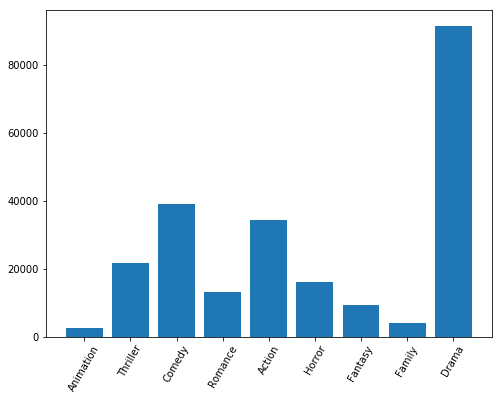

In [17]:
#Majority of movies are comedy, documentary or drama apparently.

fig = plt.figure(figsize=(8,6))
genreC = {}
for genres in df.genre:
    for genre in genres:
        try:
            genreC[genre] = genreC[genre] + 1
        except KeyError:
            genreC[genre] = 0
plt.bar(genreC.keys(), genreC.values())
plt.xticks(rotation=60)
plt.show()

In [23]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D


mlb = MultiLabelBinarizer()
mlb.fit(df.genre)
labels = mlb.classes_

maxlen = 10

num_classes = len(genreC)
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(df.movie)
vocab_size = len(tokenizer.word_index) + 1


def get_features(text_series):
    sequences = tokenizer.texts_to_sequences(text_series)
    return pad_sequences(sequences, maxlen=maxlen)

def prediction_to_label(prediction):
    tag_prob = [(labels[i], prob) for i, prob in enumerate(prediction.tolist())]
    return dict(sorted(tag_prob, key=lambda kv: kv[1], reverse=True))
    
def baseline():
    model = Sequential()
    model.add(Dense(num_classes, input_dim=maxlen, activation='relu'))
    model.add(Dense(num_classes, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
    return model

def conv1d():
    model = Sequential()
    model.add(Embedding(vocab_size, num_classes, input_length=maxlen))
    model.add(Dropout(0.1))
    model.add(Conv1D(128, 4, activation='relu', strides=1))
    model.add(GlobalMaxPool1D())
    model.add(Dense(num_classes))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
    return model

In [19]:
x = get_features(df.movie)
y = mlb.transform(df.genre)
print(x.shape)
print(y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=5000)

(165439, 10)
(165439, 9)


In [20]:
countGenres = 0
for genres in df.genre:
    countGenres = countGenres + len(genres)

class_weights = {}
for index, label in enumerate(labels):
    class_weights[index] = countGenres/genreC[label]
    print(label + " " + str(countGenres/genreC[label]))


Action 6.735493244224902
Animation 93.01845906902086
Comedy 5.926772519240111
Drama 2.5341306629351057
Family 57.936015996001
Fantasy 25.20134811915634
Horror 14.428109050168057
Romance 17.494490566037737
Thriller 10.638975582889664


In [26]:
callbacks = [
    EarlyStopping(patience=2, monitor='val_loss'),
    ModelCheckpoint(filepath='model_conv1d_final-w.h5', save_best_only=True)
]
model = conv1d()
history = model.fit(x_train, y_train,
                    class_weight=class_weights,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks)

Train on 132351 samples, validate on 33088 samples
Epoch 1/20
132351/132351 [==============================] - 36s 271us/step - loss: 3.0347 - categorical_accuracy: 0.3993 - val_loss: 0.3587 - val_categorical_accuracy: 0.4092
Epoch 2/20
132351/132351 [==============================] - 35s 261us/step - loss: 2.7851 - categorical_accuracy: 0.4239 - val_loss: 0.3538 - val_categorical_accuracy: 0.4012
Epoch 3/20
132351/132351 [==============================] - 40s 302us/step - loss: 2.6291 - categorical_accuracy: 0.4505 - val_loss: 0.3463 - val_categorical_accuracy: 0.4113
Epoch 4/20
132351/132351 [==============================] - 36s 273us/step - loss: 2.5074 - categorical_accuracy: 0.4683 - val_loss: 0.3604 - val_categorical_accuracy: 0.3818
Epoch 5/20
132351/132351 [==============================] - 36s 268us/step - loss: 2.4154 - categorical_accuracy: 0.4771 - val_loss: 0.3557 - val_categorical_accuracy: 0.3875


In [50]:
conv1d = keras.models.load_model('model_conv1d_final-w.h5')
#conv1d.evaluate(x_test, y_test)

f = get_features(["Dark Souls"])
p1 = prediction_to_label(conv1d.predict(f)[0])
df_t = pd.DataFrame()
df_t['label'] = p1.keys()
df_t['p'] = p1.values()
df_t.sort_values(by='p', ascending=False)

,label,p
3,Horror,0.707465
4,Thriller,0.441395
6,Fantasy,0.143842
8,Drama,0.120699
1,Action,0.068885
2,Comedy,0.038962
0,Animation,0.032058
7,Family,0.014869
5,Romance,0.007545
